# Lab Assignment 3: Clustering Analysis on AirBnB Manhattan Data

#### Team Members: Parker Herrin, Matthew Rosenbloom, Shazia Zaman

## Overview

For this assignment, we will be staying with our AirBnB dataset, specifically the listings during the month of May for the neighborhood group Manhattan in New York City. We will be focusing on clustering techniques to see if certain attributes or features are better (or worse) at grouping our listings based on a combination of those features. The clustering methods we will be primarily using is k-Means clustering and hierarchical agglomerative clustering and discussing the advantages of both while selecting a method that tends to explain our data most accurately.

## 1. Business Understanding

#### Describe the purpose of the dataset you selected (i.e. why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholder's needs?

The main purpose of this dataset being collected is to keep an updated list of records of the most recent listings on AirBnB's most popular destinations. Excluding the analysis previously performed on this dataset, AirBnB can use this data to analyze various trends based on the city selected, such as the quantity of listings vs. previous periods as well as pricing trends in the same manner. Additionally, the business can look at these primary metrics and provide more granular analysis by filtering on certain captured attributes such as the "Minimum Nights" or "Number of Reviews" features.

As we are focusing on clustering methods and algorithms for this analysis, we need to be able to identify what the appropriate number of clusters are combined with a reasonable statistical measure that explains the varaibility in the data, such as R-squared or accuracy. Obviously, the more clusters you end up with, the higher your ability to explain variability will be; therefore, running the algorithm through several iterations will aid us in properly selecting a "final cluster amount" to use for prediction, etc. Furthermore, in analyzing two main types of clustering techniques, we can see if certain statisitical measures and processes garner us more favorable results between each methodology.

Within the hospitality and tourism industry, when consumers are planning a trip to a specific destination, those consumers typically have a set of criteria in mind as they filter through the choices to make their selection on where they would like to stay. Performing analyses such as clustering may help to identify listings that share similar qualities with greater ease and more efficiency, thus providing the ability to the end-consumer a more ideal user experience by providing them with meaningful results and eliminating the clutter of listings that do not meet their specific criteria.

## 2. Data Understanding

#### The blocks of code below follow the process to refine our dataset for the purposes stated above. It follows a similar process as performed in our prediction model assignment, which includes one-hot encoding certain attributes, such as "Room Type," "Neighborhood" and "Price Range." All of these features may be used to some extent during the clustering procedures.

In [1]:
# Add all imports being used in the application
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from __future__ import print_function
from sklearn.cross_validation import ShuffleSplit
from sklearn import metrics as mt
from sklearn.pipeline import Pipeline
from pandas.tools.plotting import boxplot
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from IPython.html import widgets 
from sklearn import metrics as mt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

/Applications/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
# read csv file and review it
listNYC = pd.read_csv('airbnb_listings_NYC.csv', encoding = "ISO-8859-1") # read in the "listings" csv
listNYC.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,8736827,Rain or Shine Studios,45837698,Brian,Brooklyn,Sheepshead Bay,40.585989,-73.927617,Entire home/apt,2000,1,1,10/27/15,0.16,1,365
1,12270528,This is another cool listing in NYC,1667768,Martin,Manhattan,Financial District,40.704064,-74.016377,Entire home/apt,2000,1,0,NaN,NaN,2,365
2,5582283,Cozy bedroom in Brooklyn Sunsetpark,26098783,Sam,Brooklyn,Sunset Park,40.651185,-74.008421,Private room,2000,2,0,NaN,NaN,2,365
3,10549650,Prime Location Luxury Tribeca Loft,25996073,Jonathan,Manhattan,Tribeca,40.719915,-74.006409,Entire home/apt,2000,1,0,NaN,NaN,1,365
4,8515213,Studio 250 New York City,44837740,David,Manhattan,Midtown,40.755063,-73.989683,Entire home/apt,2000,1,1,1/2/16,0.25,1,351


In [3]:
#convert room type as binary variable using One-Hot encoding
room_type_enc = pd.get_dummies(listNYC['room_type'], prefix=None, prefix_sep='_', dummy_na=False, columns='room_type', sparse=False, drop_first=False)
room_type_enc.head()
listNYC = pd.concat([listNYC, room_type_enc], axis=1)
room_types = list(dict(room_type_enc.dtypes).keys())
#room_types = ['Entire home/apt', 'Private room','Shared room']

#change data type for new room types categories to integer
listNYC[room_types]=listNYC[room_types].astype(np.int64)
listNYC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32546 entries, 0 to 32545
Data columns (total 19 columns):
id                                32546 non-null int64
name                              32545 non-null object
host_id                           32546 non-null int64
host_name                         32541 non-null object
neighbourhood_group               32546 non-null object
neighbourhood                     32546 non-null object
latitude                          32546 non-null float64
longitude                         32546 non-null float64
room_type                         32546 non-null object
price                             32546 non-null int64
minimum_nights                    32546 non-null int64
number_of_reviews                 32546 non-null int64
last_review                       25076 non-null object
reviews_per_month                 25076 non-null float64
calculated_host_listings_count    32546 non-null int64
availability_365                  32546 non-null int64

In [4]:
#filter the dataset with price < 1000
listNYC = listNYC[listNYC.price <= 1000]

In [5]:
#Modify listNYC to only include required attributes and Manhattan Listings only
listNYC_man = listNYC[['neighbourhood_group','neighbourhood','room_type','Entire home/apt'
                      ,'Private room','Shared room','price','minimum_nights'
                      ,'number_of_reviews','calculated_host_listings_count'
                      ,'availability_365']]
listNYC_man = listNYC_man[(listNYC_man.neighbourhood_group == 'Manhattan')].copy(deep=True)
listNYC_man.head()

,neighbourhood_group,neighbourhood,room_type,Entire home/apt,Private room,Shared room,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
102,Manhattan,Hell's Kitchen,Entire home/apt,1,0,0,1000,1,0,1,365
106,Manhattan,Gramercy,Entire home/apt,1,0,0,1000,7,0,1,365
107,Manhattan,Morningside Heights,Entire home/apt,1,0,0,1000,1,0,2,365
109,Manhattan,West Village,Entire home/apt,1,0,0,1000,3,1,1,365
110,Manhattan,East Village,Entire home/apt,1,0,0,1000,1,0,1,364


In [6]:
#Filter data set with Manhattan neighbourhood group
listNYC_Manhattan = listNYC[(listNYC.neighbourhood_group == 'Manhattan')]
listNYC_Manhattan = listNYC_Manhattan[['neighbourhood','room_type','Entire home/apt'
                                       ,'Private room','Shared room','price'
                                       ,'minimum_nights','number_of_reviews'
                                       ,'calculated_host_listings_count','availability_365']]
listNYC_Manhattan = listNYC_Manhattan.copy(deep=True)
listNYC_Manhattan.head()

,neighbourhood,room_type,Entire home/apt,Private room,Shared room,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
102,Hell's Kitchen,Entire home/apt,1,0,0,1000,1,0,1,365
106,Gramercy,Entire home/apt,1,0,0,1000,7,0,1,365
107,Morningside Heights,Entire home/apt,1,0,0,1000,1,0,2,365
109,West Village,Entire home/apt,1,0,0,1000,3,1,1,365
110,East Village,Entire home/apt,1,0,0,1000,1,0,1,364


In [7]:
#convert neighbourhoods in Manhattan as binary variable using One-Hot encoding
neighbourhood_enc = pd.get_dummies(listNYC_Manhattan['neighbourhood'], prefix=None, prefix_sep='_', dummy_na=False, columns='neighbourhood', sparse=False, drop_first=False)
neighbourhood_enc.head()

neighbourhoods = list(dict(neighbourhood_enc.dtypes).keys())

listNYC_Manhattan = pd.concat([listNYC_Manhattan, neighbourhood_enc], axis=1)

#change data type for new neighbourhood types categories to integer
listNYC_Manhattan[neighbourhoods]=listNYC_Manhattan[neighbourhoods].astype(np.int64)
#del listNYC_Manhattan['neighbourhood']
listNYC_Manhattan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16510 entries, 102 to 32545
Data columns (total 42 columns):
neighbourhood                     16510 non-null object
room_type                         16510 non-null object
Entire home/apt                   16510 non-null int64
Private room                      16510 non-null int64
Shared room                       16510 non-null int64
price                             16510 non-null int64
minimum_nights                    16510 non-null int64
number_of_reviews                 16510 non-null int64
calculated_host_listings_count    16510 non-null int64
availability_365                  16510 non-null int64
Battery Park City                 16510 non-null int64
Chelsea                           16510 non-null int64
Chinatown                         16510 non-null int64
Civic Center                      16510 non-null int64
East Harlem                       16510 non-null int64
East Village                      16510 non-null int64
Financi

In [8]:
#print some records to evaluate
listNYC_Manhattan.head()

,neighbourhood,room_type,Entire home/apt,Private room,Shared room,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,...,Roosevelt Island,SoHo,Stuyvesant Town,Theater District,Tribeca,Two Bridges,Upper East Side,Upper West Side,Washington Heights,West Village
102,Hell's Kitchen,Entire home/apt,1,0,0,1000,1,0,1,365,...,0,0,0,0,0,0,0,0,0,0
106,Gramercy,Entire home/apt,1,0,0,1000,7,0,1,365,...,0,0,0,0,0,0,0,0,0,0
107,Morningside Heights,Entire home/apt,1,0,0,1000,1,0,2,365,...,0,0,0,0,0,0,0,0,0,0
109,West Village,Entire home/apt,1,0,0,1000,3,1,1,365,...,0,0,0,0,0,0,0,0,0,1
110,East Village,Entire home/apt,1,0,0,1000,1,0,1,364,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#create price bins for $50 incremental
bins =  [0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000]
bin_names = ['0-49','50-99','100-149','150-199','200-249','250-299','300-349','350-399','400-449','450-499','500-549','550-599','600-649','650-699','700-749','750-799','800-849','850-899','900-949','950+']
price_range = pd.cut(listNYC_Manhattan['price'], bins, labels=bin_names)
listNYC_Manhattan['price_range'] = pd.cut(listNYC_Manhattan['price'], bins, labels=bin_names)
listNYC_Manhattan.head()

,neighbourhood,room_type,Entire home/apt,Private room,Shared room,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,...,SoHo,Stuyvesant Town,Theater District,Tribeca,Two Bridges,Upper East Side,Upper West Side,Washington Heights,West Village,price_range
102,Hell's Kitchen,Entire home/apt,1,0,0,1000,1,0,1,365,...,0,0,0,0,0,0,0,0,0,950+
106,Gramercy,Entire home/apt,1,0,0,1000,7,0,1,365,...,0,0,0,0,0,0,0,0,0,950+
107,Morningside Heights,Entire home/apt,1,0,0,1000,1,0,2,365,...,0,0,0,0,0,0,0,0,0,950+
109,West Village,Entire home/apt,1,0,0,1000,3,1,1,365,...,0,0,0,0,0,0,0,0,1,950+
110,East Village,Entire home/apt,1,0,0,1000,1,0,1,364,...,0,0,0,0,0,0,0,0,0,950+


In [10]:
#convert price in Manhattan as binary variable using One-Hot encoding
price_enc = pd.get_dummies(listNYC_Manhattan['price_range'], prefix=None, prefix_sep='_', dummy_na=False, columns='price_range', sparse=False, drop_first=False)
price_enc.head()

price_bins = list(dict(price_enc.dtypes).keys())

listNYC_Manhattan = pd.concat([listNYC_Manhattan, price_enc], axis=1)

#change data type for new neighbourhood types categories to integer
listNYC_Manhattan[price_bins]=listNYC_Manhattan[price_bins].astype(np.int64)
#del listNYC_Manhattan['price_range']
listNYC_Manhattan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16510 entries, 102 to 32545
Data columns (total 63 columns):
neighbourhood                     16510 non-null object
room_type                         16510 non-null object
Entire home/apt                   16510 non-null int64
Private room                      16510 non-null int64
Shared room                       16510 non-null int64
price                             16510 non-null int64
minimum_nights                    16510 non-null int64
number_of_reviews                 16510 non-null int64
calculated_host_listings_count    16510 non-null int64
availability_365                  16510 non-null int64
Battery Park City                 16510 non-null int64
Chelsea                           16510 non-null int64
Chinatown                         16510 non-null int64
Civic Center                      16510 non-null int64
East Harlem                       16510 non-null int64
East Village                      16510 non-null int64
Financi

#### 2a. Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

Below is a detailed description of the final dataset to be used during the clustering process:

1. Neighbourhood - This is a categorical variable of the various neighbourhoods within the Manhattan burrough, which there are 32 of in total. We have also one-hot encoded each of these neighborhoods to have a binary/numerical output on whether or not the listing is within a certain neighbourhood or not.
2. Room Type - This is another categorical variable explaining the type of room that is being listed. The type is either an Entire Home or Apartment, a Private Room, or a Shared Room. We have also one-hot encoded this attribute to determine from a binary perspective if a listing is a certain room type or not.
3. Price - This is a continuous variable and is the price of the listing at the time of the analysis.
4. Minimum Nights - This is a continuous variable that specifies the minimum amount of nights a listing must be booked for. Most listings are set at low numbers ranging from 0-7 with some exceptions.
5. Number of Reviews - This is a continuous variable and is the number of reviews a listing has received as of the date the data was pulled (May 2016).
6. Calculated Host Listings Count - This is a continuous variable that is the aggregated number of listings a particular host currently has available as of the date of the listings pulled. It is based off of the hostID. If a host has 20 listings, this number will be the same (20) for each individual listing. It will not be a running or cumulative total based on the listingID.
7. Availability 365 - This is a continuous variable that provides the number of days within a calendar year that the listing is available to be booked. The distribution overall is fairly widepsread.
8. Price Range - This is a calculated discretized/categorical variable that places the given price of a listing into a price range that is currently set at $50 increments. This price range was also one-hot encoded for potential analysis purposes.

During prior analyses, we identified outliers as well as null values within the dataset and handled appropriately. Specific to this analysis, we reduced the price range to not exceed $1,000 in order to remove outliers. Furthermore, focusing specifically on Manhattan as our testing/training dataset removes possibilities of there not being enough data during the training and cross-validation processes.

#### 2b. Visualize any important attributes appropriately. Important: provide an interpretation for any charts or graphs.

##### Manhattan Listings by Neighbourhood

First, let's take a look at the distribution of listings within the Manhattan neighbourhood group to get an idea of where most of our listings are coming from.

In [11]:
listNYC_Manhattan_ngrouped = listNYC_Manhattan.groupby(by=['neighbourhood'])

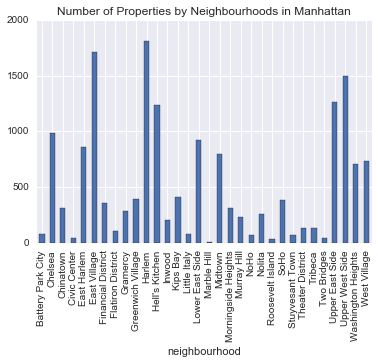

In [12]:
listNYC_Manhattan_ngrouped.neighbourhood.count().plot(kind='bar', title='Number of Properties by Neighbourhoods in Manhattan')

As we can see, there are about 5 neighbourhoods in Manhattan that have at or more than 1,000 listings for the month of May: Chelsea, East Village, Harlem, Hell's Kitchen, Upper East Side and Upper West Side. Knowing where the majority of listings reside will aid in us gaining a better understanding of our clustering results.

##### Room Type Breakdown of Manhattan

As we previously did with a different neighbourhood group in our first assignment, we should observe the breakdown of Room Types for Manahattan specifically. First, we can review a pie chart of the distribution by Room Type.

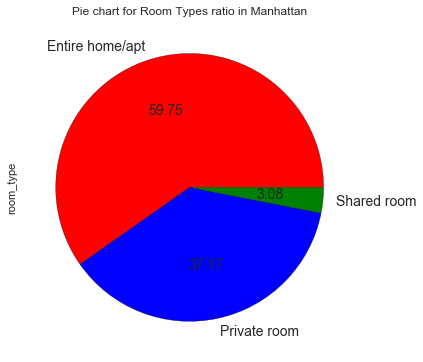

In [13]:
listNYC_Manhattan_rgrouped = listNYC_Manhattan.groupby(by=['room_type'])
room_types = listNYC_Manhattan.room_type.unique()
listNYC_Manhattan_rgrouped.room_type.count().plot.pie(labels=room_types
                                                         ,colors=['r','b','g']
                                                         ,autopct='%.2f'
                                                         ,fontsize=14
                                                         ,figsize=(6,6)
                                                         ,title='Pie chart for Room Types ratio in Manhattan' )

Similar to other neighbourhood groups and New York City as a whole, there are more "entire home/apartments" available than the other two types combined (Private Room/Shared Room). Because the "entire home/apt" listing makes up more than 50% of the listings, having "is/is not an entire home/apt" as a binary value in the clustering algorithm may be beneficial to improving our accuracy.

##### Room Type by Neighbourhood

As we now know what room type has the highest percentage of listings, we also must look at the room types by neighborhood to analyze if any particular neighborhoods offer insight that we may be able to use during our clustering process.

In [14]:
RoomType_Hood = pd.crosstab(listNYC_Manhattan.neighbourhood, listNYC_Manhattan.room_type)
RoomType_Hood

room_type,Entire home/apt,Private room,Shared room
neighbourhood,,,
Battery Park City,46,35,2
Chelsea,726,232,24
Chinatown,159,150,6
Civic Center,28,13,2
East Harlem,381,436,46
East Village,1038,642,29
Financial District,226,112,22
Flatiron District,88,14,3
Gramercy,191,88,5


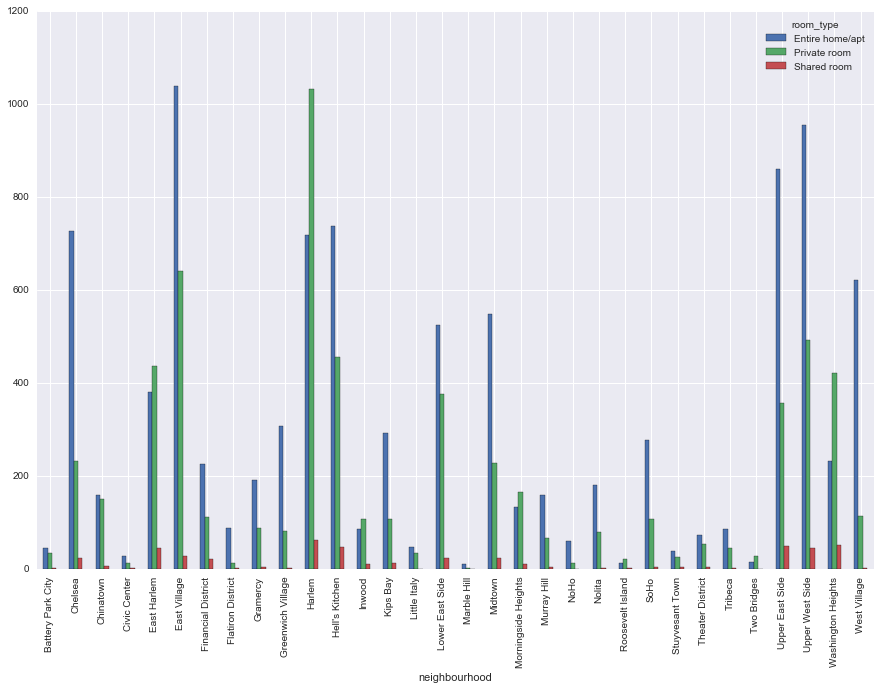

In [15]:
RoomType_Hood.plot(kind='bar',figsize=(15, 10))

As we can see, most neighbourhoods follow similar patterns as seen from the main pie chart's distribution. However, there are three neighbourhoods in partcular where the amount of Private Room listings exceed the amount of Entire Home/Apartment listings: Harlem, East Harlem, Inwood, Morningside Heights, Roosevelt Island, Two Bridges and Washington Heights. However, these neighbourhoods do not make up a sufficient amount of listings to have an impact on the overall room type distribution.

##### Histogram of Price Range Bins

As we did with the room type and the neighbourhood, understanding where most of the distribution lies for price ranges may assist in locating additional variables to include in our clustering algorithms. Below is a histogram of that distribution.

In [16]:
listNYC_Manhattan_pgrouped = listNYC_Manhattan.groupby(by=['price_range'])

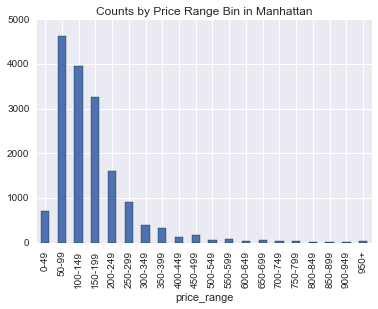

In [17]:
listNYC_Manhattan_pgrouped.price_range.count().plot(kind='bar', title='Counts by Price Range Bin in Manhattan')

As we can see above, the majority of price ranges fall between $50 and $150. Knowing this, we may include another binary value that tells us if the price range is either of these two ranges or not.

##### Scatter Plot Matrix of Selected Attributes

In order to determine if certain attributes make more sense to include in a clustering algorithm, an ideal place to start is by examining a visualization of each attribute as they relate to another. A scatter plot matrix allows us to do that all in one visualization, which is done below with all of the continuous variables within the dataset.

In [18]:
listNYC_Manhattan_scatter = listNYC_Manhattan[['price','minimum_nights','number_of_reviews','availability_365','calculated_host_listings_count']]

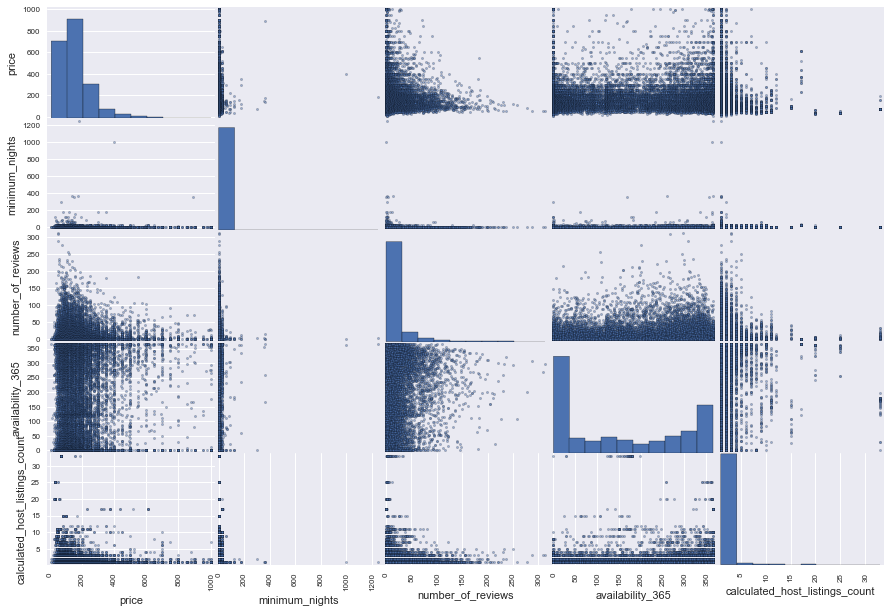

In [19]:
from pandas.tools.plotting import scatter_matrix
ax = scatter_matrix(listNYC_Manhattan_scatter,figsize=(15, 10))

Upon examination of each scatter plot above, there are several inferences we can glean from that could assist with focusing our attention on attributes that seemingly have a "clustering" type of look or feel to them, even though at this point they have not been tested or proven. Some inferences are:

1. Price seems to have its greatest effect on number of reviews, with the number of reviews vastly decreasing as the price increases. As prices rise, the number of people booking them likely decreases as well, thereby receiving fewer reviews for the listing.
2. Because the dataset is large, it somewhat gets lost in the visualization, but the relation between the availability and the number of reviews seems to have a positive correlation. As the availability number increases (meaning the listing is available more frequently throughout a given year), the more reviews there tends to be in aggregate.
3. Similar to the availability/number of reviews relation, the number of reviews seems to have a similar effect with the "caluclated host listings count" attribute. The more listings a host has, the more reviews they also tend to have in aggregate. This largely makes sense because the hosts who have more listings in general will also have more reviews; however, the way this attribute is calculated is that the count does not change per listing. For example, if a host has 20 listings, there will be individual reviews per listing, but the host listing count will be 20 for each of those listings. Therefore, if a host has several listings it does not necessarily indicate they will have more reviews.

##### Correlation Matrix of Selected Attributes

Below, we take a look at a correlation matrix to see if any of the above comparisons actually have a strong correlation or not. These correlations may be important as we attempt to understand which attributes to combine together in search of a stronger clustering algorithm.

/Applications/anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1285: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/Applications/anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1351: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


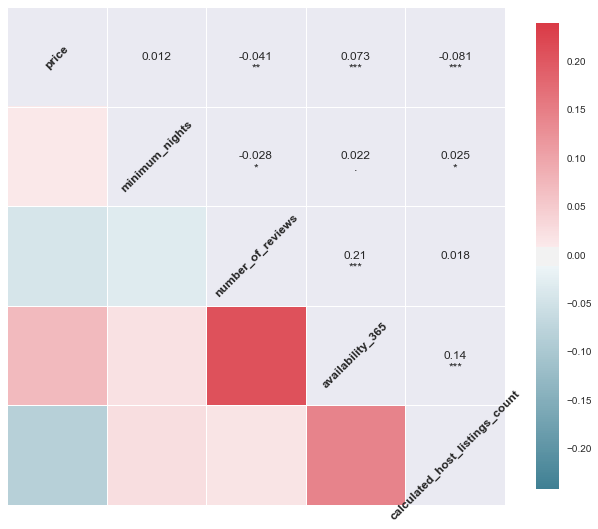

In [20]:
import seaborn as sns
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
sns.set(color_codes=True)
# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(9, 9))

sns.corrplot(listNYC_Manhattan_scatter, 
             annot=True, # plot numeric annotations?
             sig_stars=True, # plot significance?
             diag_names=True, 
             cmap=cmap, 
             ax=ax)
f.tight_layout()

At first glance, there aren't necessarily any attributes who have strong correlations with another. The highest correlation received within this matrix was "availability_365" and "number_of_reviews" at 0.21 and is also considered to be "statisitically significant." This somewhat makes sense; if the listings's availability is relatively low (which there are), the amount of reviews may be diminished due to the lack of potential consumers not booking those listings, whereas if a listing has fully open availability (365 days a year) the possibility to leave a review is wide open.

Hopefully, a combination of certain attributes will have a stronger correlation as we perform the clustering analysis on dataset.

## 3. Modeling and Evaluation

#### 3a. Train

In [21]:
# adding a column with binary value to dataset for price within range of either 50-99 or 100-149
if 'ModeratePrice' in listNYC_Manhattan.columns:
    del listNYC_Manhattan['ModeratePrice']
listNYC_Manhattan['ModeratePrice'] = np.where((listNYC_Manhattan['50-99']==1)|(listNYC_Manhattan['100-149']==1),1,0)

# print(listNYC_Manhattan.info())
print(listNYC_Manhattan[['50-99','100-149','ModeratePrice']].head())
print('Unique values for \'ModeratePrice\':',listNYC_Manhattan['ModeratePrice'].unique())

     50-99  100-149  ModeratePrice
102      0        0              0
106      0        0              0
107      0        0              0
109      0        0              0
110      0        0              0
Unique values for 'ModeratePrice': [0 1]


In [22]:
# adding a column with binary value to dataset for availability_365 being mentioned or not
if 'availability_365_mentioned' in listNYC_Manhattan.columns:
    del listNYC_Manhattan['availability_365_mentioned']

listNYC_Manhattan['availability_365_mentioned'] = np.where(listNYC_Manhattan['availability_365']>0,1,0)

# print(listNYC_Manhattan.info())
print(listNYC_Manhattan[['availability_365','availability_365_mentioned']].head())
print('Unique values for \'availability_365_mentioned\':',listNYC_Manhattan['availability_365_mentioned'].unique())

     availability_365  availability_365_mentioned
102               365                           1
106               365                           1
107               365                           1
109               365                           1
110               364                           1
Unique values for 'availability_365_mentioned': [1 0]


In [23]:
def addData(a,b,c):
    return a+b+c

In [24]:
# adding a column with value as aggregate of  entire home/apt, moderate price and availability_365_mentioned
if 'combo_mp_avail365_home' in listNYC_Manhattan.columns:
    del listNYC_Manhattan['combo_mp_avail365_home']

listNYC_Manhattan['combo_mp_avail365_home'] = listNYC_Manhattan.apply(
    lambda row: addData(row['ModeratePrice'],row['availability_365_mentioned'],row['Entire home/apt']), axis=1)

# print(listNYC_Manhattan.info())
print(listNYC_Manhattan[['ModeratePrice','availability_365_mentioned','Entire home/apt','combo_mp_avail365_home']].head())
print('Unique values for \'combo_mp_avail365_home\':',listNYC_Manhattan['combo_mp_avail365_home'].unique())

     ModeratePrice  availability_365_mentioned  Entire home/apt  \
102              0                           1                1   
106              0                           1                1   
107              0                           1                1   
109              0                           1                1   
110              0                           1                1   

     combo_mp_avail365_home  
102                       2  
106                       2  
107                       2  
109                       2  
110                       2  
Unique values for 'combo_mp_avail365_home': [2 1 0 3]


In [25]:
#get all column names to include in model as response and explanatory attributes
attributes_price_range = list(listNYC_Manhattan.price_range.unique())
print('price range attributes:', attributes_price_range)
attributes_neighbourhoods = list(listNYC_Manhattan.neighbourhood.unique())
print('neighbourhood attributes:', attributes_neighbourhoods)
attributes_room_type = list(listNYC_Manhattan.room_type.unique())
print('room type attributes:', attributes_room_type)
attributes_geo = ['latitude','longitude']
actual_attributes = ['minimum_nights','number_of_reviews','calculated_host_listings_count']

price range attributes: ['950+', '900-949', '850-899', '800-849', '750-799', '700-749', '650-699', '600-649', '550-599', '500-549', '450-499', '400-449', '350-399', '300-349', '250-299', '200-249', '150-199', '100-149', '50-99', '0-49']
neighbourhood attributes: [u"Hell's Kitchen", u'Gramercy', u'Morningside Heights', u'West Village', u'East Village', u'Midtown', u'SoHo', u'Chelsea', u'Flatiron District', u'Harlem', u'Tribeca', u'Upper West Side', u'Upper East Side', u'Financial District', u'Greenwich Village', u'Kips Bay', u'Theater District', u'Nolita', u'NoHo', u'Lower East Side', u'Little Italy', u'Chinatown', u'Murray Hill', u'Washington Heights', u'East Harlem', u'Stuyvesant Town', u'Battery Park City', u'Inwood', u'Civic Center', u'Two Bridges', u'Roosevelt Island', u'Marble Hill']
room type attributes: [u'Entire home/apt', u'Private room', u'Shared room']


In [26]:
#check accuracy for room type as Entire Home
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

y_rt = listNYC_Manhattan['Entire home/apt']
X_rt = listNYC_Manhattan[attributes_price_range+attributes_neighbourhoods]
cv = StratifiedKFold(y_rt,n_folds=10)

clf = RandomForestClassifier(n_estimators=150,random_state=1)

acc_rt = cross_val_score(clf,X_rt,y=y_rt,cv=cv)

print ("Average accuracy for room type as Entire home/apt = ", acc_rt.mean()*100, "+-", acc_rt.std()*100)

Average accuracy for room type as Entire home/apt =  74.4422187982 +- 21.5195935592


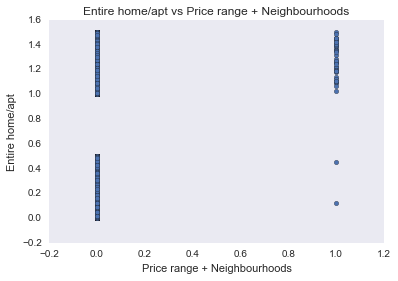

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette("Set1", 8, .75)

%matplotlib inline
X1 = listNYC_Manhattan[['Entire home/apt']+attributes_price_range+attributes_neighbourhoods].values

plt.scatter(X1[:, 1], X1[:, 0]+np.random.random(X1[:, 1].shape)/2, 
             s=20)
plt.xlabel('Price range + Neighbourhoods'), plt.ylabel('Entire home/apt')
plt.grid()
plt.title('Entire home/apt vs Price range + Neighbourhoods')
plt.show()

In [28]:
#check accuracy for moderate price as between 50 and 149
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

y_mp = listNYC_Manhattan['ModeratePrice']
X_mp = listNYC_Manhattan[attributes_neighbourhoods+['Entire home/apt']]
cv = StratifiedKFold(y_mp,n_folds=10)

clf = RandomForestClassifier(n_estimators=150,random_state=1)

acc_mp = cross_val_score(clf,X_mp,y=y_mp,cv=cv)

print ("Average accuracy for Moderate price as between 50 and 149 = ", acc_mp.mean()*100, "+-", acc_mp.std()*100)

Average accuracy for Moderate price as between 50 and 149 =  75.5139936535 +- 10.401275088


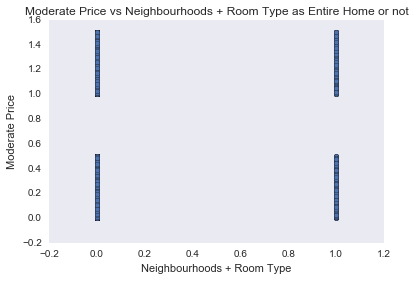

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette("Set1", 8, .75)

%matplotlib inline
X2 = listNYC_Manhattan[['ModeratePrice']+attributes_neighbourhoods+['Entire home/apt']].values

plt.scatter(X2[:, 1], X2[:, 0]+np.random.random(X2[:, 1].shape)/2,s=20)
plt.xlabel('Neighbourhoods + Room Type'), plt.ylabel('Moderate Price')
plt.grid()
plt.title('Moderate Price vs Neighbourhoods + Room Type as Entire Home or not')
plt.show()

In [30]:
print('unique values for \'number_of_reviews\':', listNYC_Manhattan['number_of_reviews'].unique())
print('unique values for \'minimum_nights\':', listNYC_Manhattan['minimum_nights'].unique())
print('unique values for \'calculated_host_listings_count\':', listNYC_Manhattan['calculated_host_listings_count'].unique())

unique values for 'number_of_reviews': [  0   1   3   2  27   6  11  29  25   5   9  20   4  71   7  15  26  72
  23  18  12  46  43   8  21  10  47  90  16  36  67  24  65  30  33  17
  13  37  39  35  56  40  60  19  75  89 103  41  57  53 106  31  50  54
  70  51 184  32  55  44  49 105  34  78  14  22  64  28  93  83  38  68
  59  85  79  45 109  73  42 124  62  58  52  66 112  91 100  99 181  77
  86  63  88 135  69  94  61 143  48 102  76 148 140  95  74  80 164  97
  84 107 142 108 113 116 186 167  82 169 157 166 145 120  96  98  92 123
 118 122 183 129 111 119 114  87 144 198 179 130 139 136 151 137 101 160
 154 127 162 126  81 185 205 138 128 208 156 132 117 149 230 141 211 104
 163 178 204 250 221 131 121 133 176 257 233 189 226 110 155 159 182 194
 168 150 174 153 161 152 146 165 158 212 134 278 199 147 172 214 125 237
 231 200 288 314 310]
unique values for 'minimum_nights': [   1    7    3    2    4    5  362   15    6   30   10   14   25   21 1000
   29  180   35   20   6

In [31]:
#check accuracy for moderate price as between 50 and 149
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

y_mp = listNYC_Manhattan['availability_365_mentioned']
X_mp = listNYC_Manhattan[['minimum_nights','calculated_host_listings_count']]
cv = StratifiedKFold(y_mp,n_folds=10)

clf = RandomForestClassifier(n_estimators=150,random_state=1)

acc_mp = cross_val_score(clf,X_mp,y=y_mp,cv=cv)
print ("Average accuracy for number of reviews = ", acc_mp.mean()*100, "+-", acc_mp.std()*100)

Average accuracy for number of reviews =  76.3234515385 +- 0.0962253715756


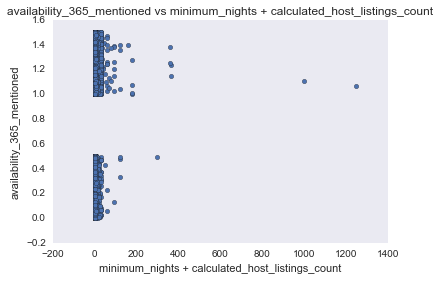

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette("Set1", 8, .75)

%matplotlib inline
X3 = listNYC_Manhattan[['availability_365_mentioned','minimum_nights','calculated_host_listings_count']].values

plt.scatter(X3[:, 1], X3[:, 0]+np.random.random(X3[:, 1].shape)/2,s=20)
plt.xlabel('minimum_nights + calculated_host_listings_count'), plt.ylabel('availability_365_mentioned')
plt.grid()
plt.title('availability_365_mentioned vs minimum_nights + calculated_host_listings_count')
plt.show()

Evaluating from the combination of features above, following two combinations comes with most accuracy.

X2 = listNYC_Manhattan[['ModeratePrice']+attributes_neighbourhoods+['Entire home/apt']]

X3 = listNYC_Manhattan[['availability_365_mentioned','minimum_nights','calculated_host_listings_count']]

We will continue analyzing these two sets of features for clustering


In [33]:
#Compute accuracy for  combination of Moderate price, Entire home/apt, Availability_365 mentioned with KMeans 
from sklearn.cluster import KMeans

X2 = listNYC_Manhattan[['ModeratePrice']+attributes_neighbourhoods+['Entire home/apt']]
X3 = listNYC_Manhattan[['availability_365_mentioned','minimum_nights','calculated_host_listings_count']]

cls = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls.fit(X2)
mpfeature = cls.labels_ # the labels from kmeans clustering

cls.fit(X3)
avail365_feature = cls.labels_

y = listNYC_Manhattan['combo_mp_avail365_home']
X = listNYC_Manhattan['number_of_reviews']
# X = np.column_stack((X,pd.get_dummies(prfeature),pd.get_dummies(mpfeature),pd.get_dummies(avail365_feature)))
X = np.column_stack((X,pd.get_dummies(mpfeature),pd.get_dummies(avail365_feature)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy (with kmeans for Combo Moderate Price, Entire home/apt, Availability365)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with kmeans for Combo Moderate Price, Entire home/apt, Availability365)=  64.0810740841 +- 6.69375167027


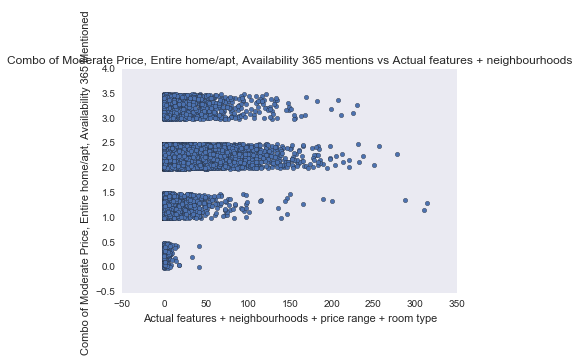

In [34]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette("Set1", 8, .75)

%matplotlib inline
X = listNYC_Manhattan[['combo_mp_avail365_home','number_of_reviews']+attributes_neighbourhoods
     +['minimum_nights','calculated_host_listings_count']].values
plt.scatter(X[:, 1], X[:, 0]+np.random.random(X[:, 1].shape)/2,s=20)
plt.xlabel('Actual features + neighbourhoods + price range + room type'), plt.ylabel('Combo of Moderate Price, Entire home/apt, Availability 365 Mentioned ' )
plt.grid()
plt.title('Combo of Moderate Price, Entire home/apt, Availability 365 mentions vs Actual features + neighbourhoods')
plt.show()

In [ ]:
#Compute accuracy for  combination of Moderate price, Entire home/apt, Availability_365 mentioned with Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

X2 = listNYC_Manhattan[['ModeratePrice']+attributes_neighbourhoods+['Entire home/apt']]
X3 = listNYC_Manhattan[['availability_365_mentioned','minimum_nights','calculated_host_listings_count']]

cls_mp = AgglomerativeClustering(n_clusters=4, linkage='ward')
cls_mp.fit(X2)
mpfeature = cls.labels_ # the labels from kmeans clustering

cls_avail365 = AgglomerativeClustering(n_clusters=4, linkage='ward')
cls_avail365.fit(X3)
avail365_feature = cls.labels_

y = listNYC_Manhattan['combo_mp_avail365_home']
X = listNYC_Manhattan['number_of_reviews']
# X = np.column_stack((X,pd.get_dummies(prfeature),pd.get_dummies(mpfeature),pd.get_dummies(avail365_feature)))
X = np.column_stack((X,pd.get_dummies(mpfeature),pd.get_dummies(avail365_feature)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy (with AgglomerativeClustering for Combo Moderate Price, Entire home/apt, Availability365)= ", acc.mean()*100, "+-", acc.std()*100)

In [37]:
#Compute accuracy for  combination of Moderate price, Entire home/apt, Availability_365 mentioned with DBScan
from sklearn.cluster import DBSCAN

X2 = listNYC_Manhattan[['ModeratePrice']+attributes_neighbourhoods+['Entire home/apt']]
X3 = listNYC_Manhattan[['availability_365_mentioned','minimum_nights','calculated_host_listings_count']]

cls = DBSCAN(eps=0.01, min_samples=5,random_state=1)

cls.fit(X2)
mpfeature = cls.labels_ # the labels from kmeans clustering

cls.fit(X3)
avail365_feature = cls.labels_

y = listNYC_Manhattan['combo_mp_avail365_home']
X = listNYC_Manhattan['number_of_reviews']
X = np.column_stack((X,pd.get_dummies(mpfeature),pd.get_dummies(avail365_feature)))

acc = cross_val_score(clf,X,y=y,cv=cv)

print ("Average accuracy (with DBScan for Combo Moderate Price, Entire home/apt, Availability365)= ", acc.mean()*100, "+-", acc.std()*100)

Average accuracy (with DBScan for Combo Moderate Price, Entire home/apt, Availability365)=  95.0988452626 +- 5.37068708584


#### 3b. Evaluate

In [35]:
#Compute accuracy for  combination of Moderate price, Entire home/apt, Availability_365 mentioned with KMeans 

X1 = listNYC_Manhattan[['Entire home/apt']+attributes_price_range+attributes_neighbourhoods].values
X2 = listNYC_Manhattan[['ModeratePrice']+attributes_neighbourhoods+['Entire home/apt']]
X3 = listNYC_Manhattan[['availability_365_mentioned','minimum_nights','calculated_host_listings_count']]

params = []
for n_ng in range(4,10):
    for n_actual in range(16,19):
        # get the first clustering
        cls_ng = KMeans(n_clusters=n_ng, init='k-means++',random_state=1)
        cls_ng.fit(X2)
        ng_feature = cls_ng.labels_ # the labels from kmeans clustering

        # append on the second clustering
        cls_actual = KMeans(n_clusters=n_actual, init='k-means++',random_state=1)
        cls_actual.fit(X3)
        actual_feature = cls_actual.labels_ # the labels from kmeans clustering

        y = listNYC_Manhattan['combo_mp_avail365_home']
        X = listNYC_Manhattan['number_of_reviews']
        X = np.column_stack((X,pd.get_dummies(ng_feature),pd.get_dummies(actual_feature )))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((n_ng,n_actual,acc.mean()*100,acc.std()*100)) # save state

        print( "Clusters",n_ng,n_actual,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Clusters 4 16 Average accuracy =  73.2405699421 +- 2.58528137857
Clusters 4 17 Average accuracy =  73.234509336 +- 2.59760128673
Clusters 4 18 Average accuracy =  73.7247066604 +- 2.93161757484
Clusters 5 16 Average accuracy =  70.6828553136 +- 5.19266500379
Clusters 5 17 Average accuracy =  70.6767983785 +- 5.19460215899
Clusters 5 18 Average accuracy =  70.8339852238 +- 5.8122855634
Clusters 6 16 Average accuracy =  65.8431984182 +- 5.92548455658
Clusters 6 17 Average accuracy =  65.8250312791 +- 5.92418832626
Clusters 6 18 Average accuracy =  65.558448998 +- 6.19228544738
Clusters 7 16 Average accuracy =  64.6861475328 +- 7.34863975912
Clusters 7 17 Average accuracy =  64.6437379783 +- 7.36564841669
Clusters 7 18 Average accuracy =  64.7649353671 +- 7.36694988174
Clusters 8 16 Average accuracy =  63.978014343 +- 6.36702971575
Clusters 8 17 Average accuracy =  63.959858212 +- 6.30283577852
Clusters 8 18 Average accuracy =  63.5661463586 +- 6.3575032426
Clusters 9 16 Average accuracy 

In [ ]:
#Compute accuracy for  combination of Moderate price, Entire home/apt, Availability_365 mentioned with Agglomerative Clustering

X1 = listNYC_Manhattan[['Entire home/apt']+attributes_price_range+attributes_neighbourhoods].values
X2 = listNYC_Manhattan[['ModeratePrice']+attributes_neighbourhoods+['Entire home/apt']]
X3 = listNYC_Manhattan[['availability_365_mentioned','minimum_nights','calculated_host_listings_count']]

params = []
for n_ng in range(5,7):
    # get the first clustering
    cls_ng = AgglomerativeClustering(n_clusters=n_ng, linkage='ward')
    cls_ng.fit(X2)
    ng_feature = cls_ng.labels_ # the labels from kmeans clustering

    # append on the second clustering
    cls_actual = AgglomerativeClustering(n_clusters=n_actual, linkage='ward')
    cls_actual.fit(X3)
    actual_feature = cls_actual.labels_ # the labels from kmeans clustering

    y = listNYC_Manhattan['combo_mp_avail365_home']
    X = listNYC_Manhattan['number_of_reviews']
    X = np.column_stack((X,pd.get_dummies(ng_feature),pd.get_dummies(actual_feature )))

    acc = cross_val_score(clf,X,y=y,cv=cv)
    params.append((n_ng,acc.mean()*100,acc.std()*100)) # save state
    print( "Clusters",n_ng,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

In [38]:
#Compute accuracy for  combination of Moderate price, Entire home/apt, Availability_365 mentioned with DBScan

X1 = listNYC_Manhattan[['Entire home/apt']+attributes_price_range+attributes_neighbourhoods].values
X2 = listNYC_Manhattan[['ModeratePrice']+attributes_neighbourhoods+['Entire home/apt']]
X3 = listNYC_Manhattan[['availability_365_mentioned','minimum_nights','calculated_host_listings_count']]

params = []
for eps in [0.1, 0.125, 0.15]:
    for mpts in range(5,8):
        # get the first clustering
        cls = DBSCAN(eps=eps, min_samples=mpts,random_state=1)
        cls.fit(X2)
        ng_feature = cls.labels_ # the labels from kmeans clustering

        # append on the second clustering
        cls.fit(X3)
        actual_feature = cls.labels_ # the labels from kmeans clustering

        y = listNYC_Manhattan['combo_mp_avail365_home']
        X = listNYC_Manhattan['number_of_reviews']
        X = np.column_stack((X,pd.get_dummies(ng_feature),pd.get_dummies(actual_feature )))

        acc = cross_val_score(clf,X,y=y,cv=cv)
        params.append((eps,mpts,acc.mean()*100,acc.std()*100)) # save state
        print( "Clusters",eps,mpts,"Average accuracy = ", acc.mean()*100, "+-", acc.std()*100)

Clusters 0.1 5 Average accuracy =  95.0988452626 +- 5.37068708584
Clusters 0.1 6 Average accuracy =  95.3532805955 +- 5.04268111031
Clusters 0.1 7 Average accuracy =  95.3048765061 +- 4.85202157753
Clusters 0.125 5 Average accuracy =  95.0988452626 +- 5.37068708584
Clusters 0.125 6 Average accuracy =  95.3532805955 +- 5.04268111031
Clusters 0.125 7 Average accuracy =  95.3048765061 +- 4.85202157753
Clusters 0.15 5 Average accuracy =  95.0988452626 +- 5.37068708584
Clusters 0.15 6 Average accuracy =  95.3532805955 +- 5.04268111031
Clusters 0.15 7 Average accuracy =  95.3048765061 +- 4.85202157753


#### 3c. Visualize

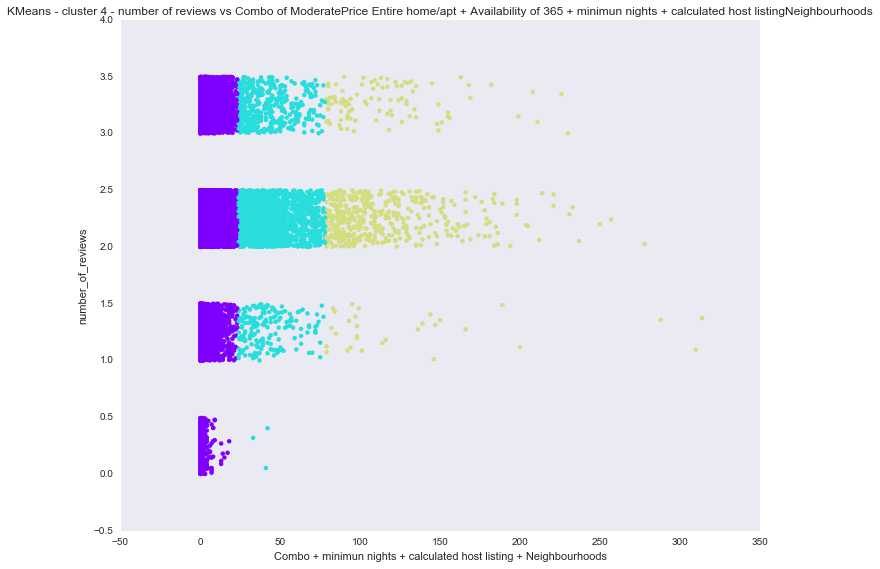

In [39]:
#Visualize with KMean
# From evaluation clustering of 4 for X2 and 16 for X3 gave the maximum accuracy
X = listNYC_Manhattan[['number_of_reviews','combo_mp_avail365_home','minimum_nights','calculated_host_listings_count']
                       + attributes_neighbourhoods]
cls = KMeans(n_clusters=4, random_state=1)
cls.fit(X)
kmn_labels = cls.labels_

fig = plt.figure(figsize=(12,8))

plt.scatter(X.iloc[:, 0], X.iloc[:, 1]+np.random.random(X.iloc[:, 1].shape)/2, c=kmn_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Combo + minimun nights + calculated host listing + Neighbourhoods'), plt.ylabel('number_of_reviews')
plt.grid()
plt.title('KMeans - cluster 4 - number of reviews vs Combo of ModeratePrice '
          + 'Entire home/apt + Availability of 365 + minimun nights + calculated host listing'
          + 'Neighbourhoods')
    
plt.tight_layout()
plt.show()

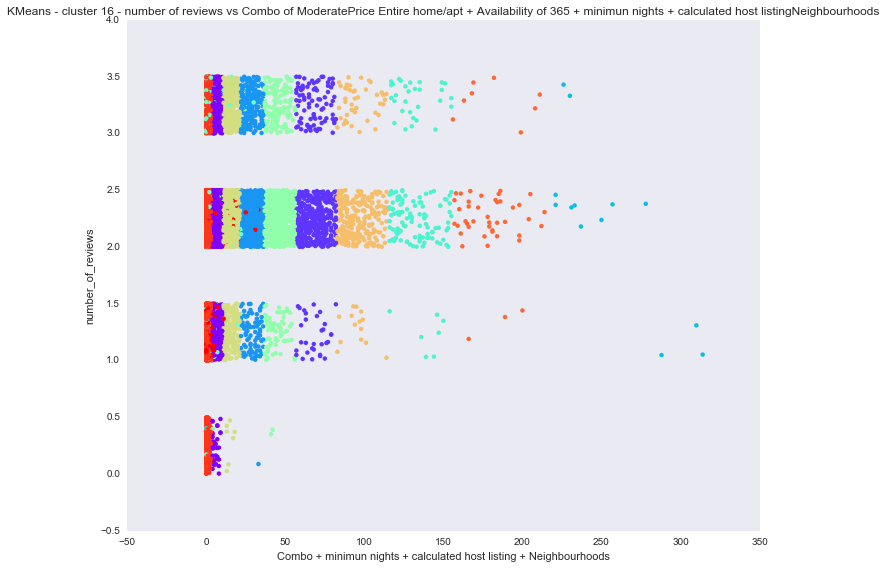

In [40]:
#Visualize with KMean
# From evaluation clustering of 4 for X2 and 16 for X3 gave the maximum accuracy
X = listNYC_Manhattan[['number_of_reviews','combo_mp_avail365_home','minimum_nights','calculated_host_listings_count']
                       + attributes_neighbourhoods]
cls = KMeans(n_clusters=16, random_state=1)
cls.fit(X)
kmn_labels = cls.labels_

fig = plt.figure(figsize=(12,8))

plt.scatter(X.iloc[:, 0], X.iloc[:, 1]+np.random.random(X.iloc[:, 1].shape)/2, c=kmn_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Combo + minimun nights + calculated host listing + Neighbourhoods'), plt.ylabel('number_of_reviews')
plt.grid()
plt.title('KMeans - cluster 16 - number of reviews vs Combo of ModeratePrice '
          + 'Entire home/apt + Availability of 365 + minimun nights + calculated host listing'
          + 'Neighbourhoods')
    
plt.tight_layout()
plt.show()

In [ ]:
#Visualize with Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

# From evaluation Agglomerative Clustering of 4 for X2 and 16 for X3 gave the maximum accuracy
X = listNYC_Manhattan[['number_of_reviews','combo_mp_avail365_home','minimum_nights','calculated_host_listings_count']
                       + attributes_neighbourhoods]
cls = AgglomerativeClustering(n_clusters=4, linkage='ward')
cls.fit(X)
kmn_labels = cls.labels_

fig = plt.figure(figsize=(12,8))

plt.scatter(X.iloc[:, 0], X.iloc[:, 1]+np.random.random(X.iloc[:, 1].shape)/2, c=kmn_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Combo + minimun nights + calculated host listing + Neighbourhoods'), plt.ylabel('number_of_reviews')
plt.grid()
plt.title('AgglomerativeClustering - cluster 4 - number of reviews vs Combo of ModeratePrice '
          + 'Entire home/apt + Availability of 365 + minimun nights + calculated host listing'
          + 'Neighbourhoods')
    
plt.tight_layout()
plt.show()

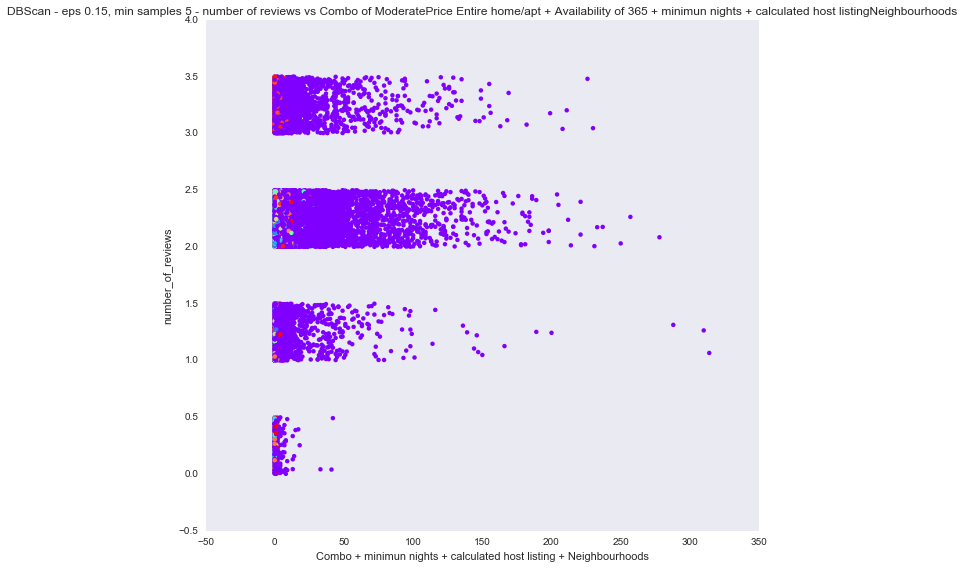

In [41]:
#Visualize with DBScan
#Clusters 0.15 5 Average accuracy =  95.5171217723 +- 4.9508083794
# From evaluation DBScan with gave the maximum acc+uracy
X = listNYC_Manhattan[['number_of_reviews','combo_mp_avail365_home','minimum_nights','calculated_host_listings_count']
                       + attributes_neighbourhoods]
cls = DBSCAN(eps=0.15, min_samples=5,random_state=1)
cls.fit(X)
kmn_labels = cls.labels_

fig = plt.figure(figsize=(12,8))

plt.scatter(X.iloc[:, 0], X.iloc[:, 1]+np.random.random(X.iloc[:, 1].shape)/2, c=kmn_labels, cmap=plt.cm.rainbow, s=20, linewidths=0)
plt.xlabel('Combo + minimun nights + calculated host listing + Neighbourhoods'), plt.ylabel('number_of_reviews')
plt.grid()
plt.title('DBScan - eps 0.15, min samples 5 - number of reviews vs Combo of ModeratePrice '
          + 'Entire home/apt + Availability of 365 + minimun nights + calculated host listing'
          + 'Neighbourhoods')
    
plt.tight_layout()
plt.show()

#### 3d. Summarize

Overall, the Agglomerative Clsutering, specifically Ward's Euclidian Distance Method, gave us the best model to work with for this particular dataset. Taking the cluster amount of the kMeans as a place to start, the same amount of clusters gave us an accuracy that was nearly 10 points better than the kMeans model. Overall, this makes sense with the way hierarchical models work, as the further certain types of listings move away from the mean, they can break off into smaller clusters. But being able to have only 4 clusters that explains 75% of the variability is a great place for the model to start.

kMeans clustering method worked fairly well for our type of data. The groups of clusters themselves are much more discernable in the kMeans clusters, specifically the cluster of 16, with there only being a handful of listings in the first few clusters (closest to the y-axis) that were mis-classified. The first tested group of clusters (4 and 16) gave us our most favorable accuracy measure with 73% and a margin of error of only 2.58%, the lowest of any subsequent cluster groupings.

DBSCAN, although its accuracy looked to be rather reasonable, may have been overfitting or overlooking certain attributes that cause the clustering to not be as ideal. It gave us an average accuracy of 95% with a margin of error of 4.5%, so its accuracy could have been anywhere from 90.5% to 99.5%.

In summary, it seems that performing an initial analysis of the attributes to gain a better understanding of where the distribution within the listings falls aided greatly in focusing on certain attributes and their makeup to create meaningful clusters. Now, it would be up to analysts and decision makers of the AirBnB team to comb through this data to see why certian listings may have been mis-classified and perhaps customize the clusters a bit more by adding more features as they deem appropriate.

## 4. Deployment

#### Be critical of your performance and tell the reader how your current model mishgt be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
Although the accuracy in most cases could have been slightly better (although a range of 65-75% is very reasonable), showing the clusters in this way can be beneficial on several fronts. Decision makers and analysts can easily identify where clusters end and begin, especially within the k-means clustering.

This type of model would mostly be used for internal decision makers of the company, but can also be utilized to help improve the experience for consumers of the site. For internal decision makers, these models could frequently be run to see if there are noticeable changes in the dynamics of a specific group of clusters. For example, if one month, the clusters seem to have a nice fit, while the next month perhaps a cluster or two are much more sparse and are not necessarily showing uniformity, analysts could go into that particular cluster to examine what may have changed with those listings to move them farther apart and essentially break up these clusters even more.

#### How useful is your model for interested parties?
The importance of our clustering algorithms is the potential to be able to identify specific traits to a city, which may have some similarities across multiple models/city types. Knowing that the majority of listings are a certain type combined with the most frequent price ranges for that city and its most frequent level of availability and then measuring it against the remaining variables is a good indicator of where the listing will fall based on those combined values and their respective means. Being able to have 4 clusters and explain approximately 73% of the variability is a reasonable place to start from. 

This information could be useful on a number of front for the interested parties. Specifically, knowing that a listing in Manhattan typically falls into one of four clusters will reduce a lot of processing time and know that the listings that are comparable to a particular listing being viewed does indeed share several similarities; however, the combination of the attributes does not necessarily spell out which atttributes are the ones causing the clustering, but rather if those listings are close enough to the mean for that particular cluster.

#### How would you deploy your model for interested parties?
This type of model would mostly be used for internal decision makers of the company, but can also be utilized to help improve the experience for consumers of the site. For internal decision makers, these models could frequently be run to see if there are noticeable changes in the dynamics of a specific group of clusters. For example, if one month, the clusters seem to have a nice fit, while the next month perhaps a cluster or two are much more sparse and are not necessarily showing uniformity, analysts could go into that particular cluster to examine what may have changed with those listings to move them farther apart and essentially break up these clusters even more. 

#### What other data should be collected?
Similar to what was suggested in previous assignments in regards to our prediction models, there could be several data points that could be additionally captured that would be unique to an individual city. For example, most tourists or visitors of New York City are interested in places to eat, tourist attractions such as the Theater District and Rockefeller Center and other locations, and mode of transportation. Having additional datapoints such as distance from Times Square, Distance from Central Park, number of restaurants in a 1-mile radius, and distance to closest subway station would all be potentially valuable attributes to capture that could really customize a user's experience and be able to view multiple listings with similar attributes and compare them based on our already-retrieved attributes, such as room type and price range. Other cities who would use clustering as a way to identify similar groups' attributes may look at similar yet somewhat different attributes that are more distinct to their city; however, most could focus around these handful of attributes.

Gathering all of these data points would be somewhat of a massive undertaking for a company such as AirBnB to do. Most likely, they would need to start with identifying where certain attributes could be made available through an API. However, if an API was not made available, several attributes could simply be housed in a dataset as a one-time collection and then updated sparingly, such as the location of subway stations and other tourist attractions as those will not change much. They could deploy these new features on a rolling basis instead of waiting until all were retrieved to see if any newly-added attributes made any kind of noticeable impact. Models could be constantly monitored and updated to take into account these changes in behavior.

#### How often would the model need to be updated, etc.?
Much like our initial prediction models, the clustering models would likely need to be updated at the same frequency, which was monthly. This also mostly has to do with the fact that AirBnB (At least in their open source data) updates most of their listings for various cities on a monthly basis.

## 5. Exceptional Work

In [1]:
import graphlab as gl

In [3]:
reviews = gl.SFrame.read_csv('reviews.csv', column_type_hints=[int,int,str,int,str,str], header = True)
reviews

Unable to parse line "Liz & Ben are the best hosts you could wish for. They are very welcoming and prepared a map with recommendations. And when Ben recommends something you should definitely try it out! One of those places is Brunswick. We went there for brunch and had the bes..."

Unable to parse line "The apartment is very close to the subway station, it takes only up to 20 minutes to reach Manhattan downtown, the place is close to the restaurants, bars and grocery store as well in Astoria neighborhood."

Unable to parse line "This was the first time we travelled with Airbnb and we love that we got to experience New York as locals do. It was such a great experience that we will turn to this platform when booking a next trip. And when coming back to New York, we would love to com..."

Unable to parse line """

Unable to parse line "The night after the weather was bad again. Alia sent us a message to warn us, and gave tips, which was very thoughtfull of her.  "

Unable to parse line "The room was very close to the subway, which was a big plus."

Unable to parse line "Best of this place was the warm and welcoming family, and smudge, the cat. ""

Unable to parse line """

Unable to parse line "It's just a few minutes ride to midtown Manhattan. "

Unable to parse line "Easy walking distance to the Meat Packing District, the Highline, Union Square and a 25 min walk up to Time Square and the Theatre district.  Only a couple of blocks to the subway if you want to give your legs a bit of a rest!  The apartment was perfect fo..."

Unable to parse line "The family was very nice and helped us whenever needed.""

Unable to parse line "We arrived to find John installing window air conditioner units, which turned out to be essential on a hot weekend.  He was extremely accommodating and responsive throughout the booking and stay."

Read 120013 lines. Lines per second: 59617.8

391269 lines failed to parse correctly

Finished parsing file /Users/pherrin/PY_MSDS_DataMining_LabAssignments/reviews.csv

Parsing completed. Parsed 509001 lines in 6.13986 secs.

listing_id,id,date,reviewer_id,reviewer_name,comments
12443007,72704773,5/4/16,817168,Emile,I had a wonderful timestaying in Keith's place ...
12443007,77426040,5/31/16,6314114,Florencia,"Espa̱ol/English Aunquenunca conocimos a Keith, ..."
12443007,80976097,6/20/16,50206819,Heleen,"Even though I never metKeith, he was helpful ..."
12221362,73887334,5/11/16,51184641,Alyssa,"July was extremely nice,attentive and answered ..."
12221362,74863385,5/17/16,3639385,S��rma,Amazingly comfortablehouse and room! Easy to ...
12221362,76312829,5/26/16,21183538,Volga,"""July ̩ stata moltogentile, la casa ̩ mo ..."
12221362,81894132,6/25/16,17083177,Hannah,July was a great host andthis was a great plac ...
9904265,77327543,5/31/16,72725151,Beth,Tammy was quick torespond to any questions ...
11553916,72385586,5/2/16,68119840,Brendan,Wonderful Neighborhoodand we were greeted at ...
11553916,73666327,5/9/16,1358222,Linda & Bernie,"Really a great place tostay. Super clean, nice ..."


Within the code, the following pieces were utilized the help shape how Turi/GraphLab/Apple's new toy saw the data.  column_type_hints=[int,int,str,int,str,str] allowed me to specify how each column was classified by GraphLab while header = True let the parser understand that the first row was the header for each column.

The Code was able to to do the following:
Read 120286 lines. 
Lines per second: 73446.7
391260 lines failed to parse correctly

120286 / (120286 + 391260) = 23.5% accurately parsed.  

This was even after going through the csv and removing the commas.  Every possible way of getting all the rows of information to correctly parse was attempted.  120,286 rows of information is still a good amount to build a sentiment analysis based upon the reviews given.

In [4]:
gl.canvas.set_target('ipynb')

Some simple Categorical Charts regarding Comments and Listing ID are below

In [5]:
reviews['word_count'] = gl.text_analytics.count_words(reviews['comments'])

reviews['comments'].show(view='Categorical')
reviews['listing_id'].show(view='Categorical')

In [6]:
reviews.show(view='Summary')

The summary statistics are above.  Some "interesting" things of note are that David, followed by Michael and Sarah, are the three top names to give reviews in this dataset.  The three most frequent words are no shocker and are "and", "the" and "a".

The top review date was 9/21/15.  A quick google search finds that a Film Festival is held on Septemer 21 through September 25 and might be a reason why it is a high response date.  The next highest date is January 5, 2016 which could correspond to the end of a traveller's New Years vacation in the city.  

In [9]:
reviews['word_count'] = gl.text_analytics.count_words(reviews['comments'])
reviews['word_count']

dtype: dict
Rows: 509001
[{'enjoy': 1, 'and': 3, 'fantastic': 1, 'feel': 1, 'had': 1, 'able': 1, 'it': 1, 'experience': 1, 'in': 3, 'our': 1, 'harlem.': 1, 'based': 1, 'everything': 1, 'make': 1, 'comfortable,': 1, "keith's": 1, 'to': 2, 'wonderful': 1, 'neighbourhood': 1, 'nyc': 1, 'was': 3, 'staying': 1, 'relaxing': 1, 'pleasant': 1, 'host': 1, 'such': 1, 'apartment.': 1, 'lovely,': 1, 'a': 3, 'room': 1, 'being': 2, 'did': 1, 'home.': 1, 'us': 1, 'i': 1, 'while': 1, 'place': 1, 'clean': 1, 'time': 1, 'the': 2, 'at': 1}, {'obviamente': 1, 'gates': 1, 'necesitabas': 1, 'pictures.': 1, 'just': 2, 'ya': 1, 'cargar': 1, 'qu̩': 2, 'esperando.': 1, 'luminoso': 1, 'buena,': 1, 'actually,': 1, 'dijo': 1, 'veces.': 1, 'como': 1, 'dinero,': 1, 'presente': 1, 'la': 5, 'lo': 2, 'beggining,': 1, 'extra': 1, 'vez': 1, 'estuvo': 2, 'parec�_a': 1, 'detalles': 1, 'to': 11, 'only': 1, 'decir': 1, 'location': 1, 'wet': 1, 'su': 1, 'argentina': 1, 'has': 1, 'in...': 1, 'asumo),': 1, 'arregl��rnosla': 1, 

The above code is an array if every word found in the reviews.  As you can see, not every word parsed correctly, thus making for quite the dirty dataset. We have 509,001 rows of information to look at for our future sentiment analysis, but as we saw previously, not every row of information could be parsed correctly.

In order to run the sentiment analysis properly, We are going to have to remove any rows with missing information.  That is what the 'reviews2' naming is for.  I run a dropna() function that removes any row missing any bit of information.  A quick sanity check shows that the arrays are the same and we can proceed to the sentiment analysis.

In [8]:
reviews2 = reviews.dropna()
reviews2['word_count']

dtype: dict
Rows: ?
[{'enjoy': 1, 'and': 3, 'fantastic': 1, 'feel': 1, 'had': 1, 'able': 1, 'it': 1, 'experience': 1, 'in': 3, 'our': 1, 'harlem.': 1, 'based': 1, 'everything': 1, 'make': 1, 'comfortable,': 1, "keith's": 1, 'to': 2, 'wonderful': 1, 'neighbourhood': 1, 'nyc': 1, 'was': 3, 'staying': 1, 'relaxing': 1, 'pleasant': 1, 'host': 1, 'such': 1, 'apartment.': 1, 'lovely,': 1, 'a': 3, 'room': 1, 'being': 2, 'did': 1, 'home.': 1, 'us': 1, 'i': 1, 'while': 1, 'place': 1, 'clean': 1, 'time': 1, 'the': 2, 'at': 1}, {'obviamente': 1, 'gates': 1, 'necesitabas': 1, 'pictures.': 1, 'just': 2, 'ya': 1, 'cargar': 1, 'qu̩': 2, 'esperando.': 1, 'luminoso': 1, 'buena,': 1, 'actually,': 1, 'dijo': 1, 'veces.': 1, 'como': 1, 'dinero,': 1, 'presente': 1, 'la': 5, 'lo': 2, 'beggining,': 1, 'extra': 1, 'vez': 1, 'estuvo': 2, 'parec�_a': 1, 'detalles': 1, 'to': 11, 'only': 1, 'decir': 1, 'location': 1, 'wet': 1, 'su': 1, 'argentina': 1, 'has': 1, 'in...': 1, 'asumo),': 1, 'arregl��rnosla': 1, 'port

Below is Turi's sentiment analysis code.  Prior to relying on Turi's built in "bag of words" for sentiment analysis, we attempted to create our own sentiment analysis utilizing the words in the review, but that required far more than 2.5 ghz Dual-Core i5 with 16 gigs of memory. In fact, when attempting a 0.1 testing/training dataset, python crashed and the activity mointor was showing more than 60 gigs of memory being utilized before the kernel crashing.  

The Turi sentiment analysis is a combination of the following:
- feature engineering: a bag-of-words transformation
- statistical model: a LogisticClassifier is used to score whether the text contains positive or negative sentiment

Predicted scores from the current model are between 0 and 1, where higher scores indicate more positive predicted sentiment.

From Turi's Website regarding their sentiment analysis:

Preprocessing: Feature engineering includes a bag-of-words representation of the text data. Both data sets have an integer "score" column with values ranging between 1 and 5, representing the number of stars that the user gave. Scores less than 3 are given a target of 0 (and thus considered to be negative sentiment during training) and ratings of more than 3 are considered positive sentiment. Reviews with a score of 3 are currently considered neutral and removed prior to training the classifier.

Accuracy: Given the above preprocessing, we observe validation set accuracies between 88-90% on both of these data sets. More details forthcoming.

Known issues: The model is currently tuned to focus on English-only text corpuses, and works best when each piece of text has similar length.

Versioning: These models may change across versions of GLC.

In [10]:
m = gl.sentiment_analysis.create(reviews2, features = ['comment'])
m.predict(reviews2)

[INFO] graphlab.toolkits.sentiment_analysis._sentiment_analysis: Downloading pretrained model...


Downloading https://static.turi.com/products/graphlab-create/resources/models/python2.7/sentiment-analysis/sentiment-combined/1/dir_archive.ini to /var/tmp/graphlab-pherrin/32735/2f16c2a8-62b9-4795-95a5-783a8b3acec2.ini

Downloading https://static.turi.com/products/graphlab-create/resources/models/python2.7/sentiment-analysis/sentiment-combined/1/objects.bin to /var/tmp/graphlab-pherrin/32735/280d255c-1355-4711-b934-edb8e3204059.bin

Downloading https://static.turi.com/products/graphlab-create/resources/models/python2.7/sentiment-analysis/sentiment-combined/1/m_10afd74819cd677e.frame_idx to /var/tmp/graphlab-pherrin/32735/7fac447b-7fd8-4539-bcc8-84089eef7f25.frame_idx

Downloading https://static.turi.com/products/graphlab-create/resources/models/python2.7/sentiment-analysis/sentiment-combined/1/m_10afd74819cd677e.sidx to /var/tmp/graphlab-pherrin/32735/f53e0ac8-2d07-4dde-a15e-6f31fdd1d992.sidx

Downloading https://static.turi.com/products/graphlab-create/resources/models/python2.7/sentiment-analysis/sentiment-combined/1/m_de100df02beb60e1.frame_idx to /var/tmp/graphlab-pherrin/32735/ddeb3a25-2675-47f4-aa41-5eb5eb7f8151.frame_idx

Downloading https://static.turi.com/products/graphlab-create/resources/models/python2.7/sentiment-analysis/sentiment-combined/1/m_de100df02beb60e1.sidx to /var/tmp/graphlab-pherrin/32735/79e0cf5d-63d3-4e6a-affd-c8544ce66375.sidx

Downloading https://static.turi.com/products/graphlab-create/resources/models/python2.7/sentiment-analysis/sentiment-combined/1/m_10afd74819cd677e.0000 to /var/tmp/graphlab-pherrin/32735/73abe099-4760-401a-8cae-c76ac665329a.0000

Downloading https://static.turi.com/products/graphlab-create/resources/models/python2.7/sentiment-analysis/sentiment-combined/1/m_de100df02beb60e1.0000 to /var/tmp/graphlab-pherrin/32735/87ebf4e2-3f03-4182-a57e-9659b72d8806.0000

dtype: float
Rows: 509000
[0.997270975576697, 0.9999990346095704, 0.9523910490848153, 0.9994110912601185, 0.9991511466261662, 0.9999999988886089, 0.9995471138053886, 0.9979521632242643, 0.9877557420637224, 0.9888548434344253, 0.9996033484082175, 0.9997113650615504, 0.9997987982239684, 0.4833357974795169, 0.22066226908522002, 0.9997592122458104, 0.998251499737849, 0.9980634857042112, 0.8069920051983421, 0.8131675751544513, 0.9956157861125858, 0.9999940285888379, 0.9998581662665049, 0.9925131065396465, 0.9984685722334232, 0.9998674916902697, 0.9986879414812496, 0.9949787269462047, 0.9894479228705194, 0.9999996798965648, 0.9917455809651037, 0.9965724794748616, 0.9999892143196005, 0.828449337308519, 0.9976870465771387, 0.9199046766497864, 0.968070489963219, 0.9361445822404314, 0.9787543089785886, 0.9979639963720907, 0.9934875602093776, 0.9942094684851771, 0.986127287125892, 0.9336062187394809, 0.9794058885412857, 0.9966303900395014, 0.99854706742185, 0.9998458149901318, 0.9996630806068427,

In [11]:
f = m['feature_extractor']
f(reviews2)

bow
"{'enjoy': 1, 'and': 3,'fantastic': 1, 'emile': ..."
"{'obviamente': 1,'gates': 1, ..."
"{'and': 2, '(but': 1,'house': 1, 'is': 2, ..."
"{'and': 2, 'feel': 1,'house': 1, 'is': 1, ..."
"{'and': 2, ':)': 1,'house': 1, ..."
"{'funzionale,': 1,'casa,': 1, 'laika': 1, ..."
"{'all': 2, 'less': 1,'questions': 1, 'shop ..."
"{'and': 4, 'respond': 1,'feel': 1, 'experience': ..."
"{'and': 4, 'guy,': 1,'neighborhood': 1, ..."
"{'a': 1, 'really': 1,'great': 1, '&': 1, ..."


In [12]:
print m['classifier']

Class                          : LogisticClassifier

Schema
------
Number of coefficients         : 2278286
Number of examples             : 1267133
Number of classes              : 2
Number of feature columns      : 1
Number of unpacked features    : 2278285

Hyperparameters
---------------
L1 penalty                     : 0.0
L2 penalty                     : 0.05

Training Summary
----------------
Solver                         : auto
Solver iterations              : 10
Solver status                  : TERMINATED: Iteration limit reached.
Training time (sec)            : 39.9574

Settings
--------
Log-likelihood                 : 68620.2104

Highest Positive Coefficients
-----------------------------
bow[streaming/gaming.]         : 15.1311
bow[whole....]                 : 15.0669
bow[2bd/3bath,]                : 13.9028
bow[later...there]             : 13.6987
bow[cris']                     : 13.6801

Lowest Negative Coefficients
----------------------------
bow[$136.]              

The Highest Positive Coefficients correspond to those that have the highest positive sentiment amongst the AirBnB reviewers.  What appears to put the biggest smile on AirBnB'ers is the internet (as it should!).  Streaming/Gaming, even when away, looks to be an important factor regarding positive sentiment to the AirBnB being rented.  The second highest might be "whole room" or "whole apartment" but am unsure.  We guess that privacy and the lack of awkwardness in sharing a random stranger's place with that stranger still there leads to a happier reviewer.  Third most important is having a a 2bd / 3 bath rental.  It's not just single people that use AirBnB; Whole families like the space as well!

As for the Lowest Coefficients, it is hard to extrapolate what many of them mean.  The third lowest score "fathom" might simply be because fathom is a strongly negative associated word that is used in place of "think" or another synonym.  The only other one we can discern is "chik-fil-a" which should bring showers of joy and merriment.  Maybe the reviewers were unhappy because the listing advertised being close to a chik-fil-a and it wasn't or maybe, just like everything else, the north messed up a southern classic.  